In [1]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import copy
from importlib import reload
import matplotlib.pyplot as plt
import multiprocessing
from IPython.display import clear_output, display
import subprocess
import glob
from pathlib import Path
import os

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

cwd = Path(os.getcwd())
telem_cam_path = Path('/opt/MagAOX/telem/campupil/')
telem_fsm_path = Path('/opt/MagAOX/telem/fsm/')

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

lamD_per_pix = 3.45e-6 / (fl * wavelength/fsm_pupil_diam) # lamD per pixel
print(1/lamD_per_pix)

as_per_pix = lamD_per_pix * as_per_lamD
print(as_per_pix)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T


18.389524275269295 arcsec
11.62890385793019
1.581363514561072 arcsec


In [2]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [30]:
npsf = 32
cam.set_roi(575, 900, npsf, client0)

In [6]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 0.


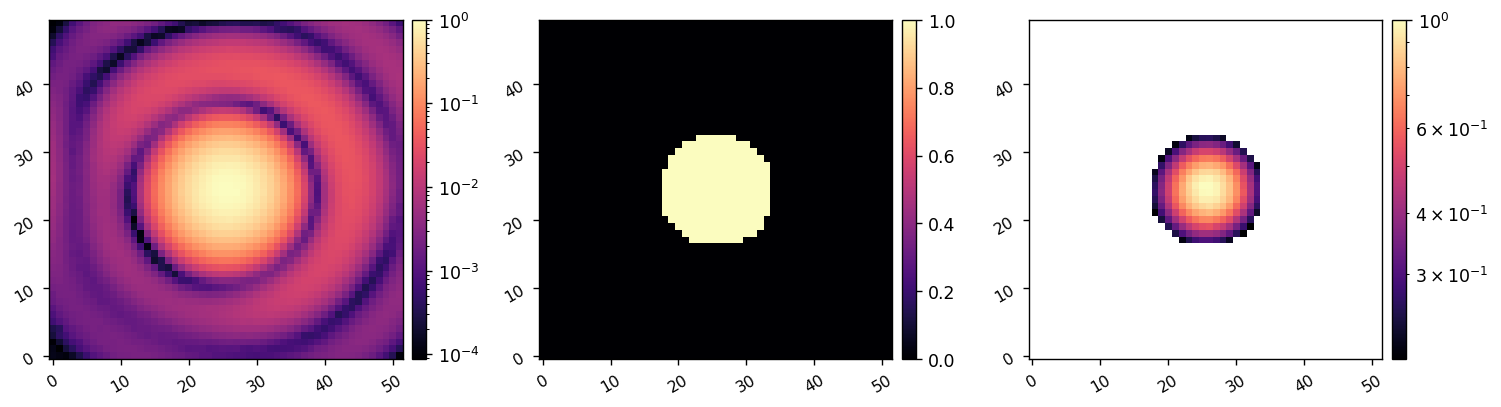

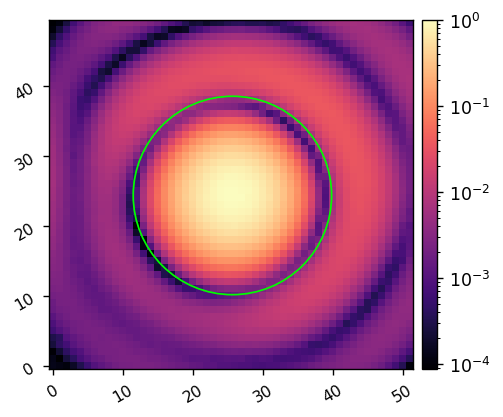

In [3]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/lamD_per_pix, fill=False, color='lime')])


# Setup FSM Interface

In [4]:
fsm_bias_channel = ImageStream('dm00disp00')
fsm_channel = ImageStream('dm00disp10')

In [5]:
fsm_bias_channel.write(v_bias)

In [109]:
fsm_bias_channel.write(zero)
fsm_channel.write(zero)

# Setup and record the modulation

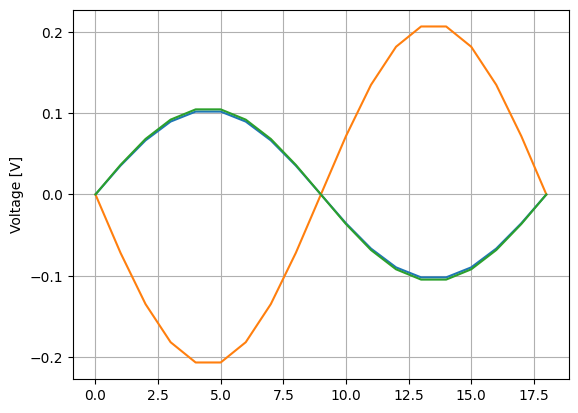

In [6]:
samps_per_wave = 19
amp = 1*u.arcsec

volt_commands = np.zeros((samps_per_wave, 3, 1))
wave = amp * np.sin(2*np.pi * np.arange(samps_per_wave)/(samps_per_wave-1))
for i in range(samps_per_wave):
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=wave[i], tilt=0*u.arcsec)
    # volt_commands[i] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=wave[i])

plt.subplot(111)
# plt.plot(wave)
plt.plot(volt_commands[:,0])
plt.plot(volt_commands[:,1])
plt.plot(volt_commands[:,2])
plt.ylabel('Voltage [V]')
plt.grid()
plt.show()

In [5]:
volt_commands[18]

array([[ 0.00000000e+00],
       [-3.56235314e-17],
       [ 3.56235314e-17]])

In [16]:
def modulate_fsm():
    print('Modulating FSM ...')
    i = 0
    while True:
        if i==samps_per_wave-1: i = 0
        fsm_channel.write(volt_commands[i])
        time.sleep(1/sin_freq/(samps_per_wave-1) - 7.5e-5)
        i += 1

mod = multiprocessing.Process(name='modulation', target=modulate_fsm, )

In [8]:
sin_freq = 1

exp_dir = f'sin-mod-tilt-{sin_freq:.2f}'
exp_path = Path(f'{cwd}/data/{exp_dir}')

subprocess.run(['mkdir',str(exp_path)])

CompletedProcess(args=['mkdir', '/home/uasal/Projects/fsm-exps/data/sin-mod-tilt-1.00'], returncode=0)

In [28]:
reload(fsm_utils)
fsm_utils.delete_all_data(exp_path)

In [29]:
mod = multiprocessing.Process(name='modulation', target=modulate_fsm, )

t_meas = 2
delay = 0.5

cam.Nframes = 100
frame0 = cam.snap()
utils.save_fits(str(exp_path/'campupil_0.fits'), frame0)

mod.start()
time.sleep(delay)
fsm_utils.toggle_telem_fsm(1, client0, )
fsm_utils.toggle_telem_campupil(1, client0)

time.sleep(t_meas)

fsm_utils.toggle_telem_fsm(0, client0)
fsm_utils.toggle_telem_campupil(0, client0)
time.sleep(delay)
mod.terminate()

fsm_channel.write(zero)


Saved data to:  /home/uasal/Projects/fsm-exps/data/sin-mod-tilt-1.00/campupil_0.fits
Modulating FSM ...


In [88]:
mod.terminate()
fsm_channel.write(zero)

# Analyze data

In [30]:
# Decompress the .xrif files from the telem_* apps into the desired data directories

subprocess.run(['xrif2fits','-d',str(telem_cam_path),'-D',exp_path])
clear_output()
subprocess.run(['xrif2fits','-d',str(telem_fsm_path),'-D',exp_path])
clear_output()

In [31]:

cam_data_fnames = sorted(glob.glob(str(exp_path/'campupil*20250206*.fits')))
fsm_data_fnames = sorted(glob.glob(str(exp_path/'dm00disp*20250206*.fits')))

fsm_data_fnames[0], cam_data_fnames[0]

('/home/uasal/Projects/fsm-exps/data/sin-mod-tilt-1.00/dm00disp_20250206215154846680079.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod-tilt-1.00/campupil_20250206215154847138124.fits')

78714.846680079
78714.847138124
-0.0004580449895001948


Text(0.5, 0, 'frame count')

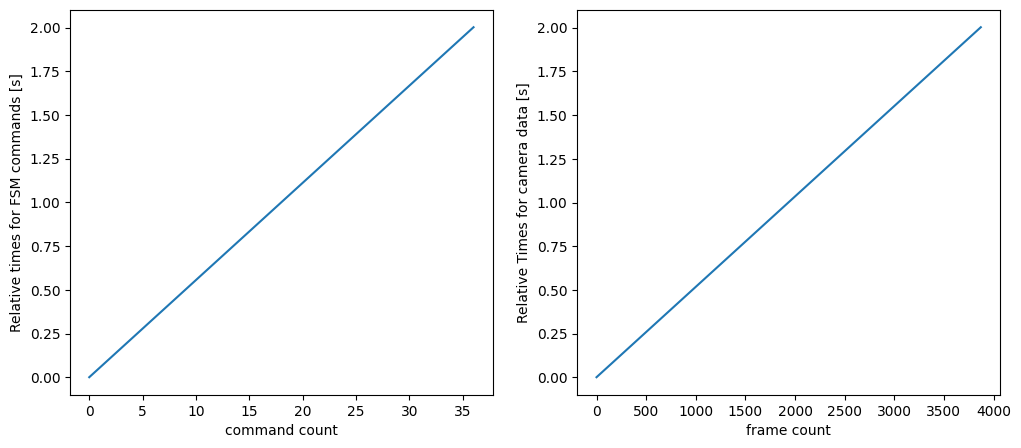

In [32]:
from astropy.io import fits

fsm_commands = []
fsm_times = []
for fname in fsm_data_fnames:
    fsm_commands.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    fsm_times.append( 3600*t_hr + 60*t_min + t_sec )
fsm_commands = np.array(fsm_commands) 
fsm_times = np.array(fsm_times)
fsm_start = fsm_times[0]
rel_fsm_times = fsm_times - fsm_start

frames = []
cam_times = []
for fname in cam_data_fnames:
    frames.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    cam_times.append( 3600*t_hr + 60*t_min + t_sec )
frames = np.array(frames) 
cam_times = np.array(cam_times)
cam_start = cam_times[0]
rel_cam_times = cam_times - fsm_start
# rel_cam_times -= rel_cam_times.min()

print(fsm_start) 
print(cam_start)
print(fsm_start - cam_start)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(rel_fsm_times)
plt.ylabel('Relative times for FSM commands [s]')
plt.xlabel('command count')

plt.subplot(122)
plt.plot(rel_cam_times)
plt.ylabel('Relative Times for camera data [s]')
plt.xlabel('frame count')

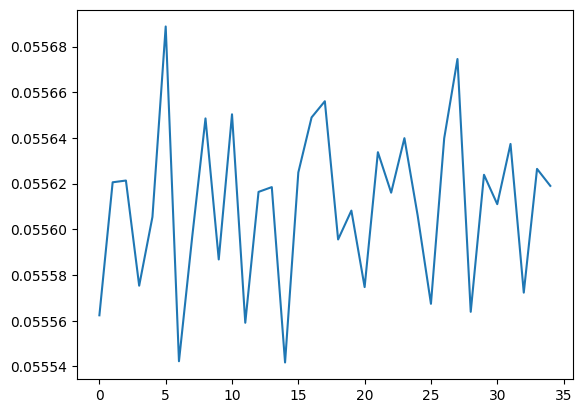

In [33]:
fsm_time_steps = (rel_fsm_times[1:] - rel_fsm_times[:-1])[:-1]
plt.plot(fsm_time_steps)

In [34]:
1/250, np.mean(fsm_time_steps), 1/np.mean(fsm_time_steps)

(0.004, np.float64(0.05561069845695913), np.float64(17.982151415954025))

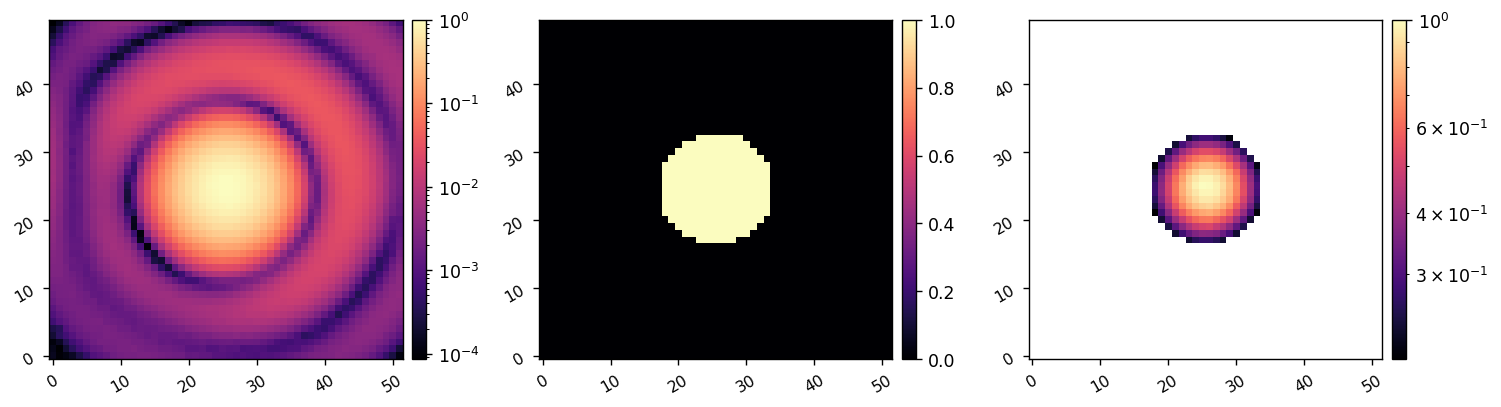

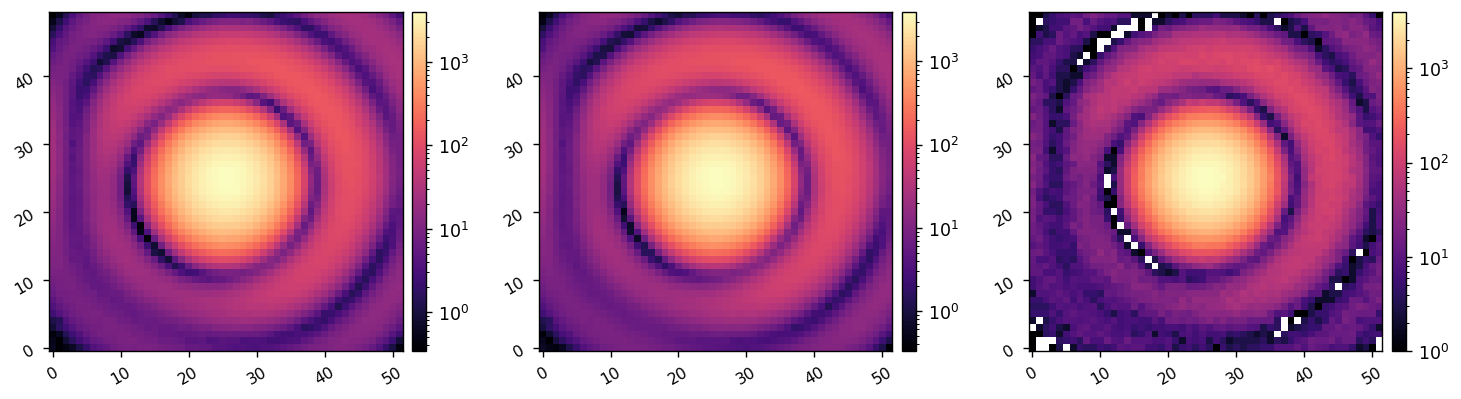

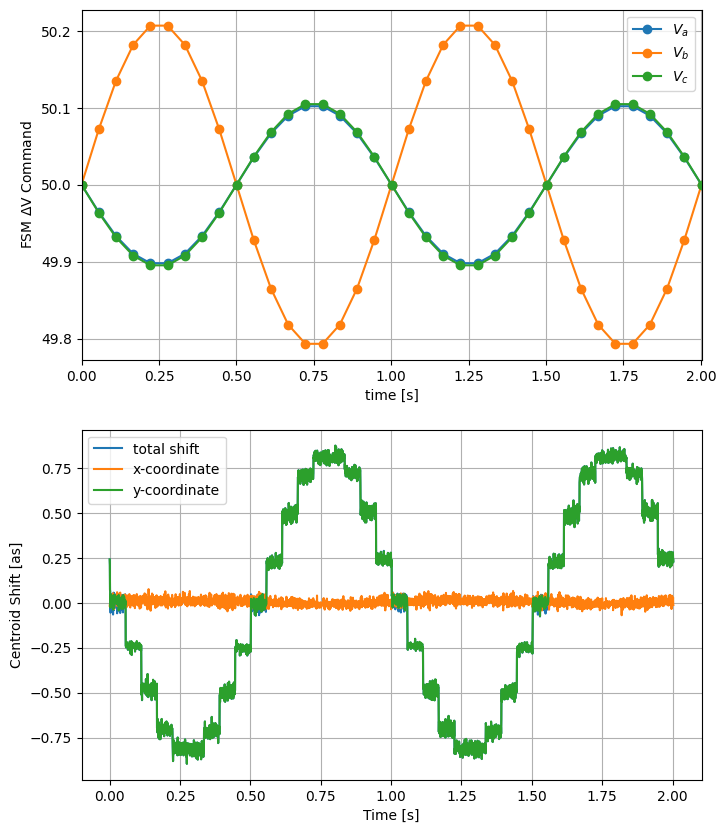

In [35]:
cthresh = 0.2

N = len(cam_data_fnames)
frame0 = utils.load_fits(str(exp_path/'campupil_0.fits'))
cen_0 = utils.centroid(frame0.astype(float), thresh=cthresh, plot=True)
mean_frame = np.mean(frames, axis=0)
imshow3(frame0, mean_frame, frames[0], lognorm=True)

shift_pix = []
total_shift_pix = []
for i in range(N):
    cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
    if shift[1]>0:
        total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[1]<0:
        total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
shift_pix = np.array(shift_pix)
total_shift_pix = np.array(total_shift_pix)

shift_as = shift_pix * as_per_pix
total_shift_as = total_shift_pix * as_per_pix

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(rel_fsm_times, fsm_commands[:,0], '-o', label='$V_a$')
plt.plot(rel_fsm_times, fsm_commands[:,1], '-o', label='$V_b$')
plt.plot(rel_fsm_times, fsm_commands[:,2], '-o', label='$V_c$')
plt.ylabel('FSM $\Delta$V Command')
plt.xlabel('time [s]')
plt.xlim([0,rel_fsm_times.max()])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.subplot(212)
# plt.plot(rel_cam_times, total_shift_pix, label='total shift')
# plt.plot(rel_cam_times, shift_pix[:,0], label='x-coordinate')
# plt.plot(rel_cam_times, shift_pix[:,1], label='y-coordinate')
# plt.ylabel('Centroid Shift [pixels]')
plt.plot(rel_cam_times, total_shift_as, label='total shift')
plt.plot(rel_cam_times, shift_as[:,0], label='x-coordinate')
plt.plot(rel_cam_times, shift_as[:,1], label='y-coordinate')
plt.ylabel('Centroid Shift [as]')
plt.xlabel('Time [s]')
# plt.xlim([0, rel_cam_times.max()])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.show()

[-1.03580633e-01  9.98996098e-01  3.20800831e-04  4.99999991e+01]


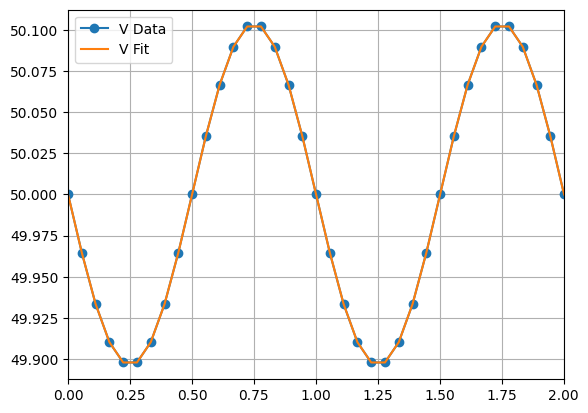

[-8.05041791e-01  1.00013556e+00 -2.02053433e-01 -2.72839082e-05]


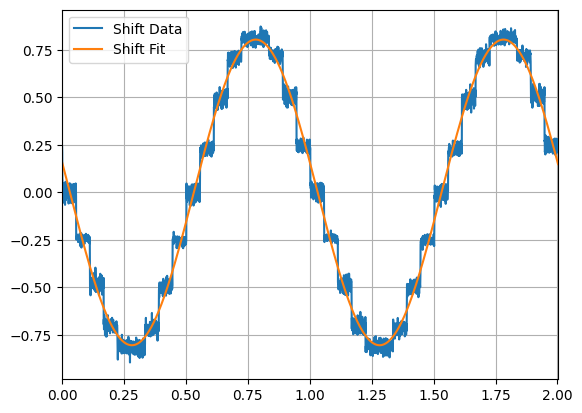

0.01838053366392931 -11.576808941610238
11.595189475274168


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sine_func(x, amp, freq, phase, offset): 
    return amp * np.sin(2*np.pi * freq * x + phase) + offset 

x = rel_fsm_times
y = fsm_commands[:,0][:,0]

amp0 = (y.max() - y.min())/2
freq0 = sin_freq
offset0 = y.max() - amp0
popt, _ = curve_fit(
    sine_func, 
    x, y, 
    p0=[amp0, freq0, 0, offset0],
    maxfev=100000,
) 
print(popt)
phase = popt[2]
if phase>np.pi/2:
    phase = popt[2] - np.pi
elif phase<-np.pi/2:
    phase = popt[2] + np.pi
fsm_data_phase = phase * 180/np.pi

# Plot results
plt.plot(x, y, '-o', label='V Data')
plt.plot(x, sine_func(x, *popt), label='V Fit')
plt.xlim([0, rel_fsm_times.max()])
plt.grid()
plt.legend()
plt.show()

x = rel_cam_times
y = total_shift_as.value

amp0 = (y.max() - y.min())/2
freq0 = sin_freq
offset0 = y.max() - amp0

popt, _ = curve_fit(
    sine_func, 
    x, y, 
    p0=[amp0, freq0, 0, offset0],
    maxfev=100000,
) 
print(popt)
phase = popt[2]
if phase>np.pi/2:
    phase = popt[2] - np.pi
elif phase<-np.pi/2:
    phase = popt[2] + np.pi
cam_data_phase = phase* 180/np.pi

# Plot results
plt.plot(x, y, label='Shift Data')
plt.plot(x, sine_func(x, *popt), label='Shift Fit')
plt.xlim([0, rel_fsm_times.max()])
plt.grid()
plt.legend()
plt.show()

rel_phase = (fsm_data_phase - cam_data_phase)
print(fsm_data_phase, cam_data_phase)
print(rel_phase)